# Allen-Cahn equation

In [1]:
import sys
import os
sys.path.append("./src")

In [2]:
import jax
import jax.numpy as jnp
import optax
from Data import *
from Plot import *
from NeuralNetwork import *
from InitialFit import *
from Solver import *

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


### Setup

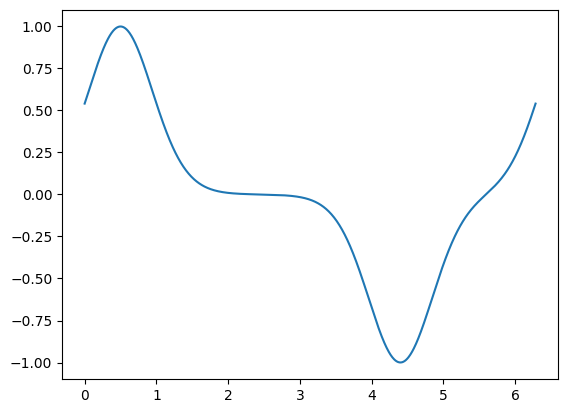

In [3]:
import numpy as np
N = 1024
L = (2 * np.pi)
x = np.linspace(0, 2 * np.pi, N)
phi = lambda x, w, b: np.exp(- w ** 2 * np.abs(np.sin(np.pi * (x - b) / L)) ** 2)
u0 = phi(x, np.sqrt(10), 0.5) - phi(x, np.sqrt(10), 4.4)
plt.plot(x, u0)

In [11]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.interpolate import interp2d

def exactAC():
    
    N = 1024 # 2048
    x = np.linspace(0, 2 * np.pi, N)
    L = 2 * np.pi
    h = L / N
    T = 12
    
    epsilon = 5e-2
    a = lambda x, t: (1.05 + t * np.sin(x))
    phi = lambda x, w, b: np.exp(- w ** 2 * np.abs(np.sin(np.pi * (x - b) / L)) ** 2)
    u0 = phi(x, np.sqrt(10), 0.5) - phi(x, np.sqrt(10), 4.4)
    
    A = - 2 * np.eye(N) + np.eye(N, k=1) + np.eye(N, k=-1)
    # periodic boundary conditions
    A[0, -2] = 1
    A[-1, 1] = 1
    
    rhs = lambda t, u: epsilon * A @ u / (h ** 2) + a(x, t) * (u - u ** 3)
    
    res = solve_ivp(rhs, [0, T], u0, method='BDF', max_step=0.01)
    
    return res.t, res.y # t, u

In [12]:
timesteps_ref, solution_ref = exactAC()

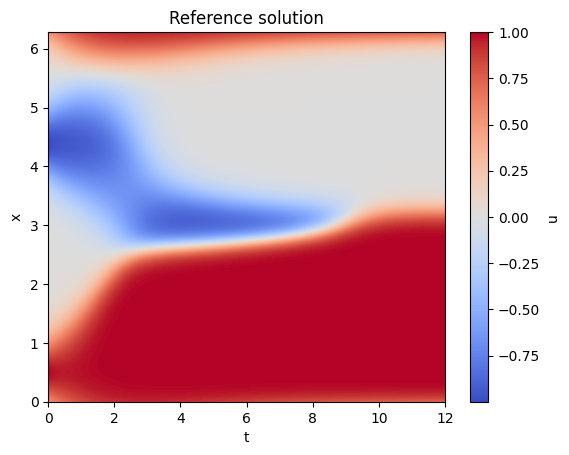

In [13]:
plt.imshow(solution_ref, cmap='coolwarm', origin='lower', extent=[0, 12, 0, 2 * jnp.pi], aspect='auto')
plt.colorbar(label='u')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Reference solution')
plt.show()

In [14]:
def exactAC_eval(x, t):
    interpolator = interp2d(timesteps_ref, jnp.linspace(problem_data.domain[0], problem_data.domain[1], 1024), solution_ref, kind='linear', fill_value='extrapolate')
    return interpolator(t.squeeze(), x.squeeze())

In [15]:
# Problem and training data

phi = lambda x, w, b: jnp.exp(- w ** 2 * jnp.abs(jnp.sin(jnp.pi * (x - b) / (2 * jnp.pi))) ** 2)
u0 = lambda x: phi(x, jnp.sqrt(10), 0.5) - phi(x, jnp.sqrt(10), 4.4)

problem_data = ProblemData(name='ac', # problem name
                           d=1, # input dimension
                           domain=(0, 2 * jnp.pi), # 1D: (lower, upper)
                           T=12, # final time
                           initial_fn=u0, # initial condition
                           exact_sol=exactAC_eval, # exact solution
                           N=2048, # number of spatial points
                           dt=0.01, # time step
                          )

training_data = TrainingData(m=2, # number of neurons per layer
                             l=3, # number of layers
                             batch_size=1000, # batch size
                             epochs=10000, # number of epochs
                             gamma=0.1, # learning rate
                             seed=0, # seed for reproducibility
                             # scheduler=optax.exponential_decay(init_value=0.1, transition_steps=1000, decay_rate=0.75) # learning rate scheduler (m = 2/4/8/16, l = 3), (m = 2/4/8/16, l = 4), (m = 2/4/8, l = 5)
                             scheduler=optax.linear_schedule(init_value=0.1, end_value=0.001, 
                                                             transition_steps=1000, transition_begin=1000) # learning rate scheduler (m = 10, l = 1/2/3/4)
                             # scheduler=optax.piecewise_constant_schedule(init_value=0.1, boundaries_and_scales={1000: 0.1}) # learning rate scheduler
                             #scheduler=optax.cosine_decay_schedule(init_value=0.1, decay_steps=1000) # learning rate scheduler
                            )

In [16]:
# neurons_list = [2, 4, 8, 16]
# layers_list = [3, 4, 5]

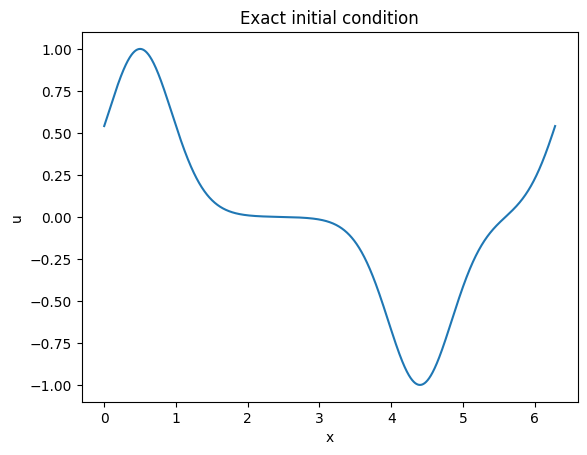

In [17]:
plot_function(problem_data.initial_fn, problem_data, 'Exact initial condition')

In [18]:
print(problem_data)

Problem data:
  name: ac, d: 1, domain: (0, 6.283185307179586), T: 12, N: 2048, dt: 0.01


In [19]:
print(training_data)

Training data:
  m: 2, l: 3, batch size: 1000, epochs: 10000, gamma: 0.1, seed: 0, scheduler: <function polynomial_schedule.<locals>.schedule at 0x7f662ae45c60>


### Initial fit

In [20]:
# Neural network

net = DeepNetAC(training_data.m, training_data.l, problem_data.domain[1] - problem_data.domain[0])
print(net)

DeepNetAC(
    # attributes
    m = 2
    l = 3
    L = 6.283185307179586
)


In [21]:
# Initial fit

initial_fit = False # True to train a NN to fit the initial condition, False otherwise

if initial_fit:
    theta = init_neural_galerkin(net, problem_data, training_data) # train a NN to fit the initial condition
    jnp.save('./data/theta_init_' + problem_data.name + '_m' + str(training_data.m) + '_l' + str(training_data.l) + '_' + str(training_data.seed) + '.npy', theta)
else:
    theta = jnp.load('./data/theta_init_' + problem_data.name + '_m' + str(training_data.m) + '_l' + str(training_data.l) + '_' + str(training_data.seed) + '.npy', allow_pickle=True).item()
    x_plot = jnp.linspace(problem_data.domain[0], problem_data.domain[1], problem_data.N).reshape(-1, 1)
    relative_error = jnp.linalg.norm(net.apply(theta, x_plot.reshape(-1, 1)) - u0(x_plot)) / jnp.linalg.norm(u0(x_plot))
    print("Relative error of the initial fit:", relative_error)

Relative error of the initial fit: 0.0062920586


### Time evolution

In [22]:
# Source term for the AC equation

def rhs_ac(theta_flat, x, t, u_fn):
    epsilon = 5e-2
    a = lambda x, t: (1.05 + t * jnp.sin(x)).squeeze()
    U = jax.vmap(u_fn, (None, 0)) # jax.vmap(fun, in_axes)
    U_ddx = jax.vmap(gradsqz(gradsqz(u_fn, 1), 1), (None, 0))
    u = U(theta_flat, x)
    u_xx = U_ddx(theta_flat, x)
    return epsilon * u_xx + a(x, t) * (u - u ** 3)

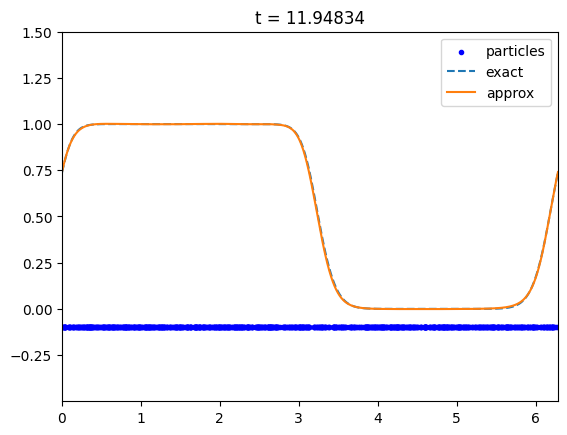

In [22]:
solution, timesteps, diagnostic = neural_galerkin(theta=theta, # initial parameters
                                                  net=net, # neural network
                                                  problem_data=problem_data, # problem data
                                                  n=1000, # sample points
                                                  rhs=rhs_ac, # problem RHS
                                                  x_init=None,
                                                  sampler='uniform',
                                                  scheme='rk45',
                                                  diagnostic_on=True # save conditioning number and singular values of the mass matrix
                                                 )

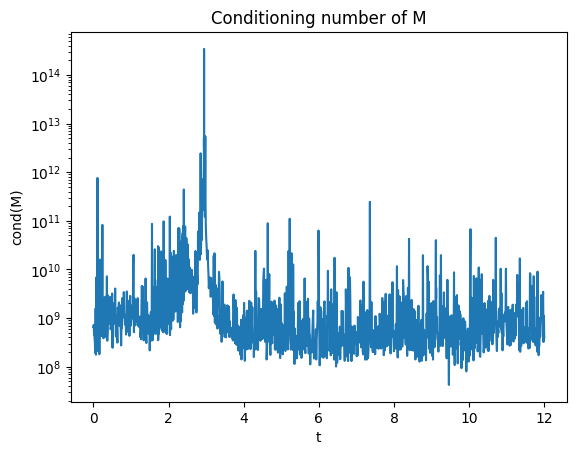

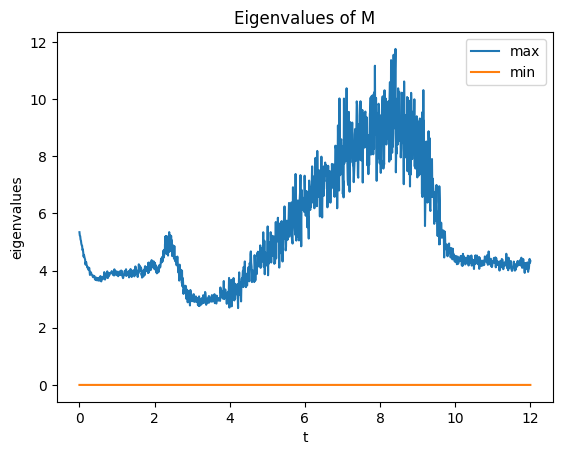

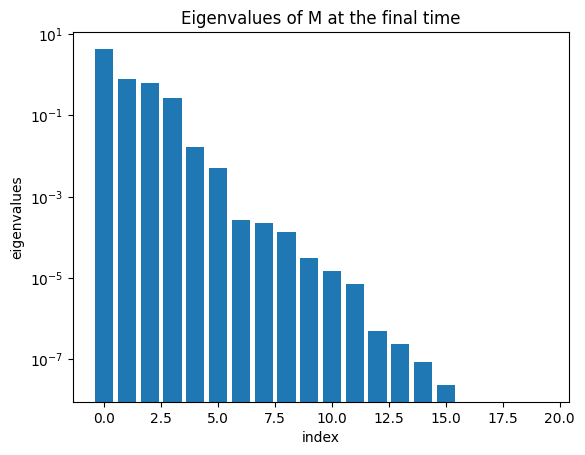

In [23]:
diagnostic.plot(timesteps)

### Conditioning w.r.t. number of samples

In [16]:
# samples_list = [100, 200, 400, 1000, 2000, 4000, 8000, 16000, 24000, 32000]
samples_list = [48000]
time_list = []
cond_list = []
# max_eig_list = []
# min_eig_list = []

for samples in samples_list:
    
    print(f'Running model with {samples} samples...')
    
    time_sum = 0.0
    cond_list_int = []
    cond_nan = 0
    
    for i in range(5): # repeat each run 5 times
        start = time.time()
        solution, timesteps, diagnostic = neural_galerkin(theta=theta, # initial parameters
                                                          net=net, # neural network
                                                          problem_data=problem_data, # problem data
                                                          n=samples, # sample points
                                                          rhs=rhs_ac, # problem RHS
                                                          x_init=None,
                                                          sampler='uniform',
                                                          scheme='rk45',
                                                          diagnostic_on=True, # save conditioning number and singular values of the mass matrix
                                                          plot_on=False,
                                                          seed=1000*i
                                                         )
        end = time.time()
        time_sum += end - start
        cond = diagnostic.averaged()[0]
        if jnp.isnan(cond):
            cond_nan += 1
        else:
            cond_list_int.append(cond)
            print(cond)
    
    print(f'{cond_nan} NaN condition numbers detected.')
    print(cond_list_int)
    time_list.append(time_sum / 5.0)
    cond_list.append(cond_list_int)
    # avg_cond, avg_max_eig, avg_min_eig = diagnostic.averaged()
    # cond_list.append(avg_cond)
    # max_eig_list.append(avg_max_eig)
    # min_eig_list.append(avg_min_eig)

Running model with 48000 samples...
Run time evolution...
ERROR! Session/line number was not unique in database. History logging moved to new session 915
Elapsed time: 1755.377 s
244626570000.0
Run time evolution...
Elapsed time: 1640.063 s
37194100000.0
Run time evolution...
Elapsed time: 1842.363 s
59347600000.0
Run time evolution...
Elapsed time: 1868.942 s
37210170000.0
Run time evolution...
Elapsed time: 2092.672 s
27179778000.0
0 NaN condition numbers detected.
[Array(2.4462657e+11, dtype=float32), Array(3.71941e+10, dtype=float32), Array(5.93476e+10, dtype=float32), Array(3.721017e+10, dtype=float32), Array(2.7179778e+10, dtype=float32)]


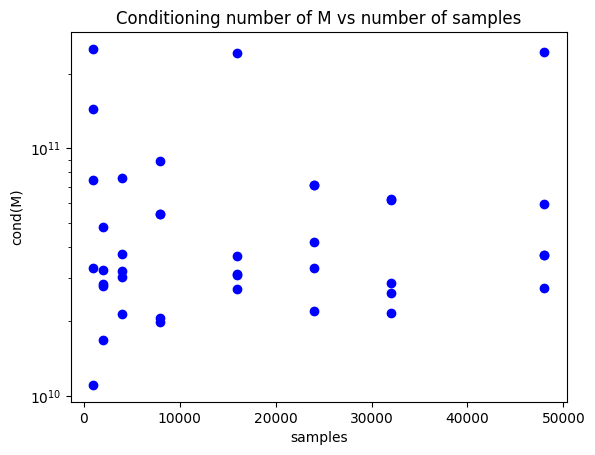

In [17]:
# samples_list = [100, 200, 400, 1000, 2000, 4000, 8000, 16000, 24000, 32000, 48000]
samples_list = [1000, 2000, 4000, 8000, 16000, 24000, 32000, 48000]

cond_list = [# [2.028082e+10, 5.85677e+10, 4.1490477e+10, 2.488609e+11, 2.4187021e+11],
             # [3.4361004e+10, 2.4221078e+10, 4.446868e+10, 3.3294303e+10, 1.8269641e+11],
             # [5.695443e+10, 2.2879506e+11, 1.7608747e+10, 7.274138e+10, 3.640767e+10],
             [2.5181025e+11, 1.1078329e+10, 1.4368086e+11, 7.448406e+10, 3.2940229e+10],
             [4.799793e+10, 2.8382247e+10, 3.2119814e+10, 2.7763192e+10, 1.6790941e+10],
             [3.0176379e+10, 2.1379293e+10, 3.1906521e+10, 7.616265e+10, 3.745115e+10],
             [2.0608598e+10, 8.843168e+10, 5.441647e+10, 1.9863425e+10, 5.4266315e+10],
             [2.70206e+10, 2.422895e+11, 3.11774e+10, 3.6847514e+10, 3.0706104e+10],
             [3.2906353e+10, 2.2098608e+10, 7.086643e+10, 7.1280394e+10, 4.1676734e+10],
             [6.1884297e+10, 2.6054038e+10, 2.8543267e+10, 6.255393e+10, 2.1522878e+10],
             [2.4462657e+11, 3.71941e+10, 5.93476e+10, 3.721017e+10, 2.7179778e+10]
            ]

# cond_avg = jnp.array([jnp.mean(jnp.array(cond)) for cond in cond_list])
# cond_std = jnp.array([jnp.std(jnp.array(cond)) for cond in cond_list])
for idx, samples in enumerate(samples_list):
    for c in range(len(cond_list[idx])):
        plt.scatter(samples, cond_list[idx][c], c='b')
# plt.plot(samples_list, cond_avg, 'r-*', label='avg')
# plt.plot(samples_list, cond_avg + cond_std, 'r:')
# plt.plot(samples_list, cond_avg - cond_std, 'r:')
# plt.plot(samples_list, 1 / jnp.sqrt(jnp.array(samples_list)) * 5e12, 'r--', label='1/sqrt(n)')
plt.title('Conditioning number of M vs number of samples')
plt.xlabel('samples')
plt.ylabel('cond(M)')
# plt.xscale('log')
plt.yscale('log')
# plt.legend()
plt.show()

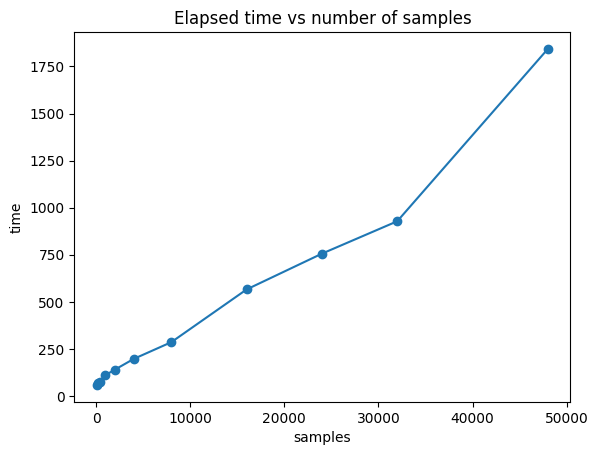

In [21]:
samples_list = [100, 200, 400, 1000, 2000, 4000, 8000, 16000, 24000, 32000, 48000]
time_list = [59, 69, 73, 111, 140, 197, 286, 566, 756, 928, 1843]
plt.plot(samples_list, time_list, 'o-')
plt.title('Elapsed time vs number of samples')
plt.xlabel('samples')
plt.ylabel('time')
plt.show()

In [15]:
# plt.plot(samples_list, max_eig_list)
# plt.plot(samples_list, min_eig_list)
# plt.title('Eigenvalues of M vs number of samples')
# plt.xlabel('samples')
# plt.ylabel('eigenvalues')
# plt.legend(['max', 'min'])
# plt.show()

### Rank w.r.t. number of samples

In [35]:
samples_list = [1000, 2000, 4000, 8000, 16000]

rank_list = []

for samples in samples_list:

    print(f'Running model with {samples} samples...')
    
    start = time.time()
    solution, timesteps, diagnostic = neural_galerkin(theta=theta, # initial parameters
                                                      net=net, # neural network
                                                      problem_data=problem_data, # problem data
                                                      n=samples, # sample points
                                                      rhs=rhs_ac, # problem RHS
                                                      x_init=None,
                                                      sampler='uniform',
                                                      scheme='rk45',
                                                      diagnostic_on=True, # save conditioning number and singular values of the mass matrix
                                                      plot_on=False,
                                                     )
    end = time.time()
    
    rank_list.append(diagnostic.rank)

Running model with 16000 samples...
Run time evolution...
Elapsed time: 570.383 s


In [39]:
jnp.max(jnp.array(rank_list[0]))

Array(13, dtype=int32)

In [37]:
jnp.min(jnp.array(rank_list[0]))

Array(10, dtype=int32)

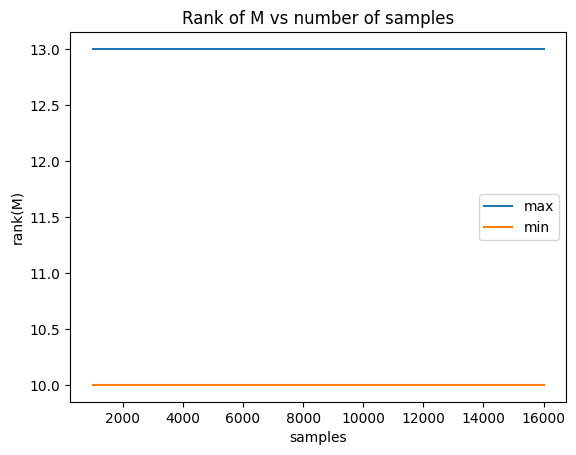

In [40]:
samples_list = [1000, 2000, 4000, 8000, 16000]
rank_max = [13, 13, 13, 13, 13]
rank_min = [10, 10, 10, 10, 10]
plt.plot(samples_list, rank_max, label='max')
plt.plot(samples_list, rank_min, label='min')
plt.title('Rank of M vs number of samples')
plt.xlabel('samples')
plt.ylabel('rank(M)')
plt.legend()
plt.show()

### Conditioning w.r.t. number of parameters

In [26]:
neurons_list = [2, 4, 8] # [2, 4, 8, 16]
layers_list = [3, 4, 5]
cond_list = []
theta_len = []

for layers in layers_list:
    for neurons in neurons_list:

        print(f'Running model with {neurons} neurons and {layers} layers...')
    
        theta = jnp.load('./data/theta_init_' + problem_data.name + '_m' + str(neurons) + '_l' + str(layers) + '_' + str(training_data.seed) + '.npy', allow_pickle=True).item()
        
        theta_flat, _ = jax.flatten_util.ravel_pytree(theta)
        print(f'm = {neurons}, l = {layers}: {len(theta_flat)} params')
        theta_len.append(len(theta_flat))
        
        net = DeepNetAC(neurons, layers, problem_data.domain[1] - problem_data.domain[0])
        
        solution, timesteps, diagnostic = neural_galerkin(theta=theta, # initial parameters
                                                          net=net, # neural network
                                                          problem_data=problem_data, # problem data
                                                          n=1000, # sample points
                                                          rhs=rhs_ac, # problem RHS
                                                          x_init=None,
                                                          sampler='uniform',
                                                          scheme='rk45',
                                                          diagnostic_on=True, # save conditioning number and singular values of the mass matrix
                                                          plot_on=False
                                                         )
    
        avg_cond, _, _ = diagnostic.averaged()
        cond_list.append(avg_cond)

Running model with 2 neurons and 3 layers...
m = 2, l = 3: 20 params
Run time evolution...
Elapsed time: 94.575 s
Running model with 4 neurons and 3 layers...
m = 4, l = 3: 56 params
Run time evolution...
Elapsed time: 149.479 s
Running model with 8 neurons and 3 layers...
m = 8, l = 3: 176 params
Run time evolution...
Elapsed time: 783.341 s
Running model with 2 neurons and 4 layers...
m = 2, l = 4: 26 params
Run time evolution...
Elapsed time: 101.534 s
Running model with 4 neurons and 4 layers...
m = 4, l = 4: 76 params
Run time evolution...
Elapsed time: 218.673 s
Running model with 8 neurons and 4 layers...
m = 8, l = 4: 248 params
Run time evolution...
Elapsed time: 1298.632 s
Running model with 2 neurons and 5 layers...
m = 2, l = 5: 32 params
Run time evolution...
Elapsed time: 115.273 s
Running model with 4 neurons and 5 layers...
m = 4, l = 5: 96 params
Run time evolution...
Elapsed time: 357.213 s
Running model with 8 neurons and 5 layers...
m = 8, l = 5: 320 params
Run time

In [27]:
cond_list

[Array(2.5181025e+11, dtype=float32),
 Array(8.3834085e+10, dtype=float32),
 Array(8.253262e+15, dtype=float32),
 Array(9.7535885e+11, dtype=float32),
 Array(1.2460706e+12, dtype=float32),
 Array(4.499316e+13, dtype=float32),
 Array(1.6136385e+10, dtype=float32),
 Array(4.3355208e+13, dtype=float32),
 Array(2.7060675e+15, dtype=float32)]

In [ ]:
# [Array(2.5181025e+11, dtype=float32),
#  Array(8.3834085e+10, dtype=float32),
#  Array(8.253262e+15, dtype=float32),
#  Array(9.7535885e+11, dtype=float32),
#  Array(1.2460706e+12, dtype=float32),
#  Array(4.499316e+13, dtype=float32),
#  Array(1.6136385e+10, dtype=float32),
#  Array(4.3355208e+13, dtype=float32),
#  Array(2.7060675e+15, dtype=float32)]

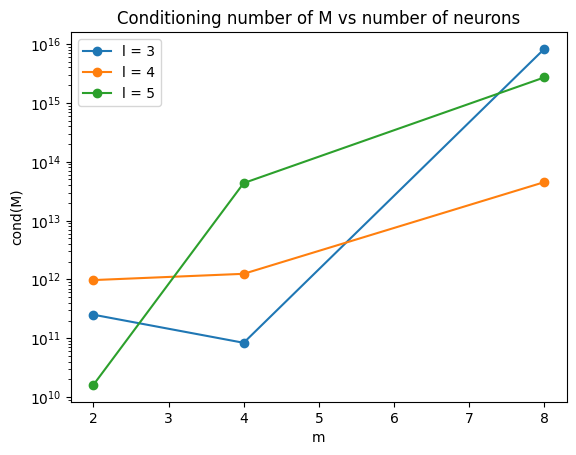

In [6]:
neurons_list = [2, 4, 8]
cond_list = [2.5181025e+11, 8.3834085e+10, 8.253262e+15, 9.7535885e+11, 1.2460706e+12, 4.499316e+13, 1.6136385e+10, 4.3355208e+13, 2.7060675e+15]
theta_len = [20, 56, 176, 26, 76, 248, 32, 96, 320]
plt.semilogy(neurons_list, cond_list[0:3], 'o-')
plt.semilogy(neurons_list, cond_list[3:6], 'o-')
plt.semilogy(neurons_list, cond_list[6:], 'o-')
plt.title('Conditioning number of M vs number of neurons')
plt.xlabel('m')
plt.ylabel('cond(M)')
plt.legend(['l = 3', 'l = 4', 'l = 5'])
plt.show()

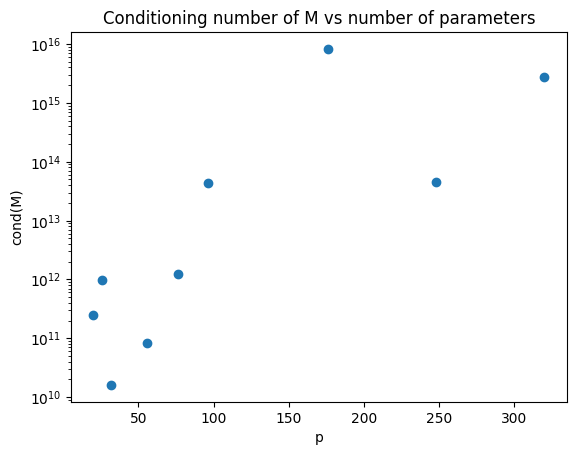

In [5]:
plt.semilogy(theta_len, cond_list, 'o')
plt.title('Conditioning number of M vs number of parameters')
plt.xlabel('p')
plt.ylabel('cond(M)')
plt.show()

### Comparison with regularized least squares

In [26]:
reg_list = [0.0, 1e-8, 1e-6, 1e-4, 1e-2]
cond_list = []
errors_list = []
timesteps_list = []

for reg in reg_list:

    solution, timesteps, diagnostic = neural_galerkin(theta=theta, # initial parameters
                                                      net=net, # neural network
                                                      problem_data=problem_data, # problem data
                                                      n=1000, # sample points
                                                      rhs=rhs_ac, # problem RHS
                                                      x_init=None,
                                                      reg=reg, # regularization parameter
                                                      sampler='uniform',
                                                      scheme='rk45',
                                                      plot_on=False,
                                                      diagnostic_on=True # save conditioning number and singular values of the mass matrix
                                                     )

    timesteps_list.append(timesteps)
    cond_list.append(diagnostic.averaged()[0])
    errors = compute_error(solution, timesteps, exactAC_eval, problem_data)
    errors_list.append(errors)

Run time evolution...
Elapsed time: 122.437 s


/tmp/ipykernel_32139/112990203.py:2: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolator = interp2d(timesteps_ref, jnp.linspace(problem_data.domain[0], problem_data.domain[1], 1024), solution_ref, kind='linear', fill_value='extrapolate')
/tmp/ipykernel_32139/112990203.py:3: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, 

Run time evolution...
Elapsed time: 166.938 s


/tmp/ipykernel_32139/112990203.py:2: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolator = interp2d(timesteps_ref, jnp.linspace(problem_data.domain[0], problem_data.domain[1], 1024), solution_ref, kind='linear', fill_value='extrapolate')
/tmp/ipykernel_32139/112990203.py:3: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, 

Run time evolution...
Elapsed time: 131.238 s


/tmp/ipykernel_32139/112990203.py:2: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolator = interp2d(timesteps_ref, jnp.linspace(problem_data.domain[0], problem_data.domain[1], 1024), solution_ref, kind='linear', fill_value='extrapolate')
/tmp/ipykernel_32139/112990203.py:3: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, 

Run time evolution...
Elapsed time: 72.596 s


/tmp/ipykernel_32139/112990203.py:2: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolator = interp2d(timesteps_ref, jnp.linspace(problem_data.domain[0], problem_data.domain[1], 1024), solution_ref, kind='linear', fill_value='extrapolate')
/tmp/ipykernel_32139/112990203.py:3: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, 

Run time evolution...
Elapsed time: 64.127 s


/tmp/ipykernel_32139/112990203.py:2: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolator = interp2d(timesteps_ref, jnp.linspace(problem_data.domain[0], problem_data.domain[1], 1024), solution_ref, kind='linear', fill_value='extrapolate')
/tmp/ipykernel_32139/112990203.py:3: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, 

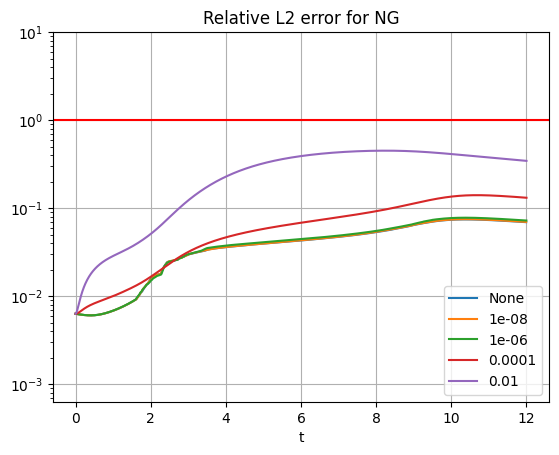

In [29]:
for i in range(len(reg_list)):
    t_plot = jnp.array(timesteps_list[i])
    errors = jnp.array(errors_list[i])
    if i == 0:
        plt.semilogy(t_plot, errors, linestyle='-', label='None')
    else:
        plt.semilogy(t_plot, errors, linestyle='-', label=reg_list[i])
plt.axhline(y=1, color='r', linestyle='-')
plt.xlabel('t')
plt.ylim([min(1e-3, 1e-1 * jnp.min(errors)), max(1e1, 1e1 * jnp.max(errors))])
plt.title('Relative L2 error for NG')
plt.grid()
plt.legend()
plt.show()

In [28]:
print(cond_list)

[Array(2.3860963e+10, dtype=float32), Array(4.457836e+09, dtype=float32), Array(5728112.5, dtype=float32), Array(48975.875, dtype=float32), Array(329.04245, dtype=float32)]


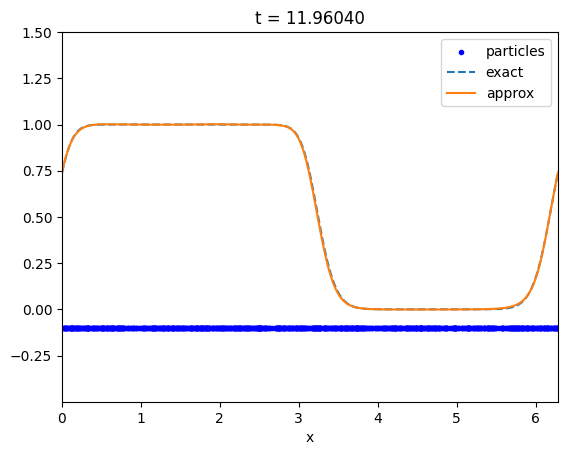

Elapsed time: 213.476 s


In [16]:
solution, timesteps, diagnostic = neural_galerkin(theta=theta, # initial parameters
                                                  net=net, # neural network
                                                  problem_data=problem_data, # problem data
                                                  n=1000, # sample points
                                                  rhs=rhs_ac, # problem RHS
                                                  x_init=None,
                                                  sampler='uniform',
                                                  scheme='rk45',
                                                  diagnostic_on=True # save conditioning number and singular values of the mass matrix
                                                 )

In [19]:
diagnostic.averaged()[0]

Array(4.457836e+09, dtype=float32)

In [17]:
errors = compute_error(solution, timesteps, exactAC_eval, problem_data)

/tmp/ipykernel_31343/112990203.py:2: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, for regular grids use `RegularGridInterpolator` instead.
For scattered data, prefer `LinearNDInterpolator` or
`CloughTocher2DInterpolator`.

For more details see
`https://scipy.github.io/devdocs/notebooks/interp_transition_guide.html`

  interpolator = interp2d(timesteps_ref, jnp.linspace(problem_data.domain[0], problem_data.domain[1], 1024), solution_ref, kind='linear', fill_value='extrapolate')
/tmp/ipykernel_31343/112990203.py:3: DeprecationWarning: `interp2d` is deprecated in SciPy 1.10 and will be removed in SciPy 1.14.0.

For legacy code, nearly bug-for-bug compatible replacements are
`RectBivariateSpline` on regular grids, and `bisplrep`/`bisplev` for
scattered 2D data.

In new code, 

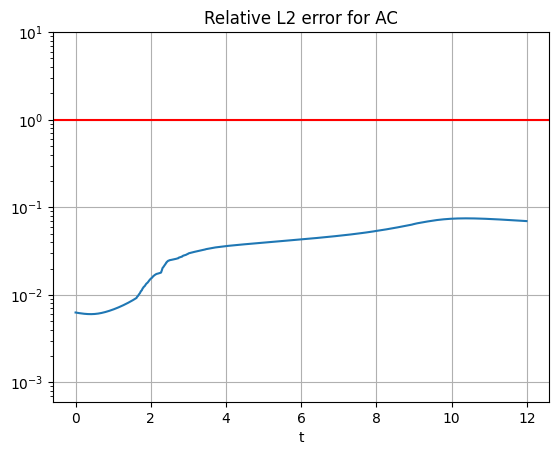

In [18]:
plot_error(errors, timesteps, 'Relative L2 error for AC')